Note there are some global variables I declare that may cause you to call on other functions before graphing and using other capabilities. One example of this is calling on the 'spline' function I created, before you are able to graph the difference between helices and the beta-sheets.

## Initiating the Code

The first step in the process was to use my terminal to activate the Jupyter notebook and import any packages I needed. For a Chromebook using Linux it was somewhat challenging to figure out, but once I was able to get the notebook running it wasn't too bad to bring it up again (such as when I turned off the computer and had to launch the terminal again). The biggest problem I still run into is sometimes the terminal will close by itself (probably due to the high computer usage).

To activate Jupyter using Linux the code is as follows (inputting this into the terminal):

sudo bash Miniconda3-latest-Linux-x86_64.sh
(type yes)
/opt/miniconda3
(type yes)
sudo chown -R peek28mjay /opt/miniconda3
source /opt/miniconda3/bin/activate
conda create --name conda_env
conda activate conda_env
conda config --add channels conda-forge
conda install jupyter
jupyter notebook --generate-config
conda install r-irkernel
conda install rpy2
conda install numpy
conda install pandas
conda install statsmodels
conda install matplotlib
conda install seaborn
jupyter notebook

When relaunching the terminal after initial setup...
source /opt/miniconda3/bin/activate
conda activate conda_env
jupyter notebook

In [28]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from scipy import interpolate
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.interpolate import BarycentricInterpolator

## Protein Data and Graph

The first step in the programming process was to read in the protein text files. A few important things to note are that the text files had every character read as a string originally, so I had to convert the strings to integer-type data, and the only line I needed for the points of the protein was found in line 3, and lastly I made most variables global so I could work with them outside specific cells. A sample of a protein text file can be found below...

In [1]:
## open('protein0.txt').readlines()

In [30]:
def obtain(proteins):
    pro = open(proteins)
    pro_info = pro.readlines()
    prolist = pro_info[3]
    pro = prolist.replace('[', '')
    pro = pro.replace(']', '')    
    pro = pro.split(", ")
    pro = [pro[n:n+3] for n in range(0,len(pro), 3)]
    
    global xdata
    xdata = []
    for n in range(0, len(pro)):
        xdata.append(float(pro[n][0]))
    global ydata
    ydata = []
    for n in range(0, len(pro)):
        ydata.append(float(pro[n][1]))
    global zdata
    zdata = []
    for n in range(0, len(pro)):
        zdata.append(float(pro[n][2]))
    
    global protein
    protein = []
    global index
    index = []
    for a in range(0, len(pro)):
        protein.append([xdata[a],ydata[a],zdata[a]])
        index.append(a)
    
def graph(protein):
    fig = plt.figure(figsize = [12, 10])
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xdata, ydata, zdata, '.r-', c='r', marker='o')
    ax.plot(xdata, ydata, zdata, color = 'b')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()

I used the keyword 'obtain' to access the protein, where the input is a text file. Note before I could access the text file it had to be saved into my Linux files (which one can do by opening the folder and dragging the files over). My next step was to graph the protein, which was fairly simple and is as follows...

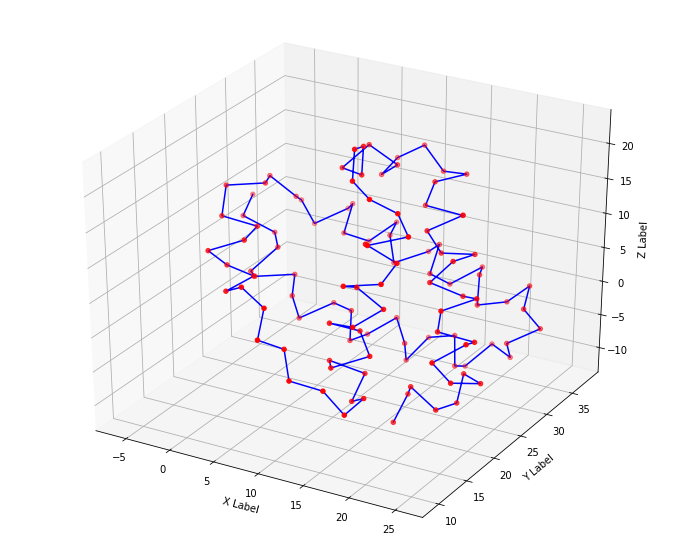

In [46]:
obtain('protein0.txt')
graph(protein)

## Discrete Helicity Function

For the discrete helicity function, Professor Segert and I used some averaging to evaluate discrete derivatives and then took some cross-products. While I did not focus on the discrete helicity function mathematically, but worked on my own helicity function, the cross-products were then checked for norms between consecutive vectors, which will give way to some of my explanation for the cubic spline helicity function. Therefore, I will provide the results of the discretized helicity function on a protein and then the normed graph will be explained more thoroughly when I use it for my interpolation helicity function.

In [32]:
def helD_seg(protein):
    unit_vec=[]
    new_vec=[]
    yes = []
    no = []
    na = []
    ne = []
    nu = []
    ni = []
    final = []
    global norm_data
    norm_data = []
    global coord_data
    coord_data = []

    for a in range(0, len(protein)-1):
        unit_vec.append(np.subtract(protein[a+1],protein[a]) / 
        ((np.subtract(protein[a+1],protein[a]))**2).sum()**0.5)
    
    for a in range(0, len(unit_vec)-1):
        new_vec.append(np.add(unit_vec[a],unit_vec[a+1]) /
        ((np.add(unit_vec[a], unit_vec[a+1]))**2).sum()**0.5)   

    for a in range(1, len(new_vec)):
        yes.append(np.cross(new_vec[a],new_vec[a-1]))

    for a in range(0, len(yes)-1):
        no.append(np.subtract(yes[a+1],yes[a]))
        na.append(no[a] / (no[a]**2).sum()**0.5)
        ne.append(np.add(na[a], na[a-1]))
        nu.append(ne[a] / (ne[a]**2).sum()**0.5)

    for a in range(0,len(nu)-1):
        ni.append(np.cross(nu[a],nu[a+1]))
        final.append(ni[a] / (ni[a]**2).sum()**0.5)

    for a in range(1, len(final)):
        norm_data.append((np.subtract(final[a],final[a-1])**2).sum()**0.5)
        coord_data.append(a)
    
    norm_data[0]=2
    norm_data[1]=2
    norm_data[len(norm_data)-1]=2
    norm_data[len(norm_data)-2]=2
    norm_data[len(norm_data)-3]=2
    
    plt.scatter(coord_data, norm_data)
    plt.show()

In [33]:
def graph_seg(protein,threshold):
    keep = []
    discard = []
    for a in range(0,len(coord_data)-1):
        if norm_data[a] < threshold:
            keep.append(a)
        if norm_data[a] >= threshold:
            discard.append(a)

    global seg_x
    global seg_y
    global seg_z
    global noseg_x
    global noseg_y
    global noseg_z
    seg_x=[]
    seg_y=[]
    seg_z=[]
    noseg_x = []
    noseg_y = []
    noseg_z = []
    for a in keep:
        seg_x.append(protein[a][0])
        seg_y.append(protein[a][1])
        seg_z.append(protein[a][2])
    for a in discard:
        noseg_x.append(protein[a][0])
        noseg_y.append(protein[a][1])
        noseg_z.append(protein[a][2])
    
    new_fig = plt.figure(figsize = [12, 10])
    new_ax = new_fig.add_subplot(111, projection='3d')
    new_ax.scatter(seg_x, seg_y, seg_z, '.r-', c='b', marker='o')
    new_ax.scatter(noseg_x, noseg_y, noseg_z, '.r-', c='r', marker='o')
    new_ax.plot(xdata, ydata, zdata, color = 'y')
    new_ax.set_xlabel('X Label')
    new_ax.set_ylabel('Y Label')
    new_ax.set_zlabel('Z Label')
    plt.show()

The plot of the norms allowed us to set a threshold and if the residues did not meet the requirement, then they were discarded as residues on 𝛽-sheets. For example, in the protein backbone shown below I set a threshold of 0.25 for the normed difference, which meant that every residue that had a value of less than 0.25 in the plot above would be considered to lie on a helix.

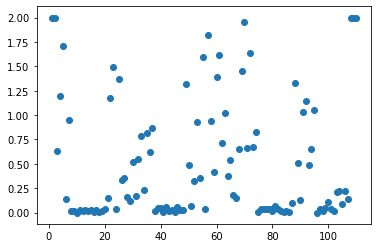

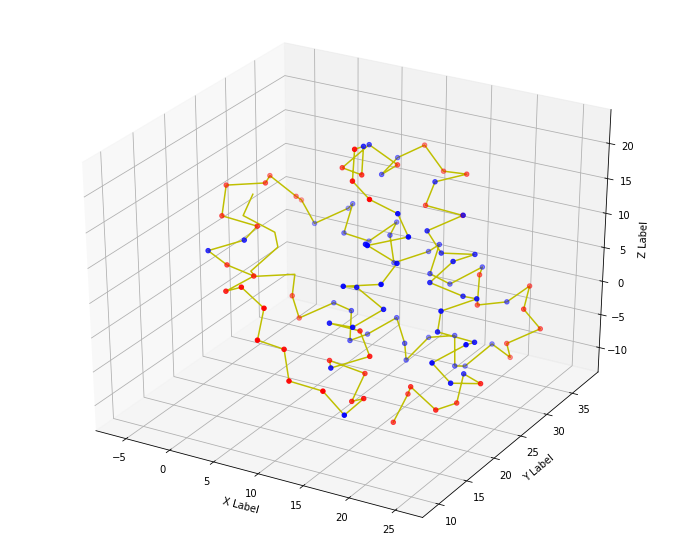

In [34]:
helD_seg(protein)
graph_seg(protein, 0.25)

After using different cutoffs for the helicity threshold (which comes from a norm so values range from 0 to 2), we had another student working on the machine learning aspect run the data through to see if we coule better characterize the protein by just looking at the helices. This attempt didn't offer much in terms of characterizing proteins, so throughout the process I was also working on my own helicity function.

I thought about using cubic splines to approximate the data and allow more ease for taking derivatives and cross products of vectors, while this was harder to translate into three-dimensions as I initially thought, at the end of the day it was a simple line of code I had to include.

## Background on Cubic Splines

Attempting my own method to evaluate helicity, I decided to try and use cubic splines, which will allow for smooth functions and their derivatives. Using a cubic spline, I can then use formulas similar to the Frenet-Seret formulas to evaluate helicity. First I will give a quick demonstration of what a cubic spline is and some features it provides.

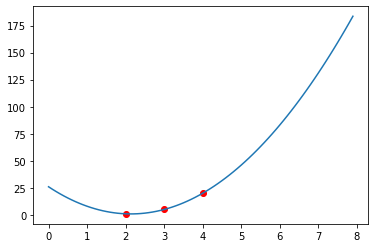

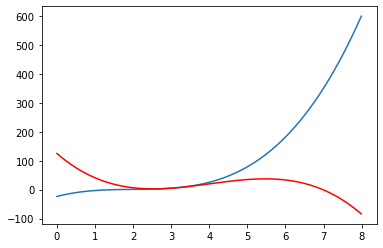

In [35]:
inputs = [2, 3, 4]
outputs = [1, 5, 20]
values = np.arange(0,8,0.1)
cs = CubicSpline(inputs,outputs)
plt.scatter(inputs,outputs,c='r')
plt.plot(values,cs(values))
plt.show()

t = np.arange(0,8,0.01)
plt.plot(t, 1+1.25*(t-2)+2.75*(t-2)**3)
plt.plot(t, 5+9.5*(t-3)+8.25*(t-3)**2-2.75*(t-3)**3, c='r')
plt.show()

Cubic splines are useful for interpolating a set of points as cubic polynomials provide concavity and are the smallest degree polynomials that provide inflection points. On the other hand, polynomial interpolation attempts to fit a polynomial of lowest degree to the data set, contrasting from the local perspective of cubic splines. Cubic splines are advantageous over other forms of interpolation due to the avoidance of Runge’s Phenomenon, while giving a similar estimation. Runge’s Phenomenon occurs when using a higher order polynomial for interpolation and causes oscillation towards the end points that may not resemble the original function and therefore increases the error associated with the interpolation.

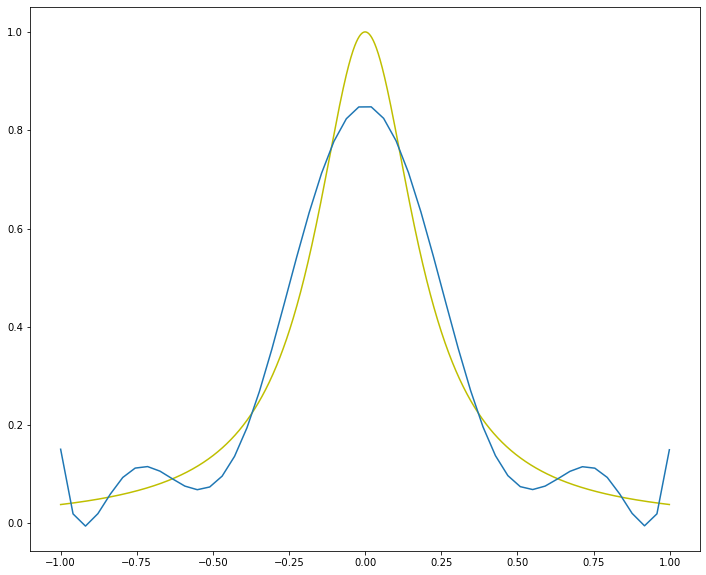

In [47]:
t = np.arange(-1, 1, 0.001)
Runge = 1/(1+25*t**2)
runge = np.polyfit(t, Runge, 8)
tt = np.linspace(min(t),max(t))
yy = np.polyval(runge,tt)

plt.figure(figsize = [12, 10])
plt.plot(t, Runge, c='y')
plt.plot(tt, yy)
plt.show()

With a new C2 function modeling the data, I can now generalize the procedure to three dimensions in order to evaluate derivatives of the proteins.

## Cubic Splines to Evaluate Helicity

The first step in the process of creating a new helicity function was to interpolate the residues on the protein backbone. While Python had a convenient method for two-dimensional graphs of cubic splines, it required some trial and error to adapt the Python package to a three-dimensional protein. After numerous attempts, I was able to interpolate along each set of coordinates separately and then combine my three cubic splines into a three-dimensional spline.

In [37]:
def spline(protein):
    fig = plt.figure(figsize = [12, 10])
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xdata, ydata, zdata, '.r-', c='r', marker='o')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    k=len(xdata)
    data = list(range(k))
    global test
    test = np.arange(0,k,0.1)
    global csx
    global csy
    global csz
    csx = CubicSpline(data,xdata[0:k])
    csy = CubicSpline(data,ydata[0:k])
    csz = CubicSpline(data,zdata[0:k])
    plt.plot(csx(test),csy(test),csz(test))
    plt.show()

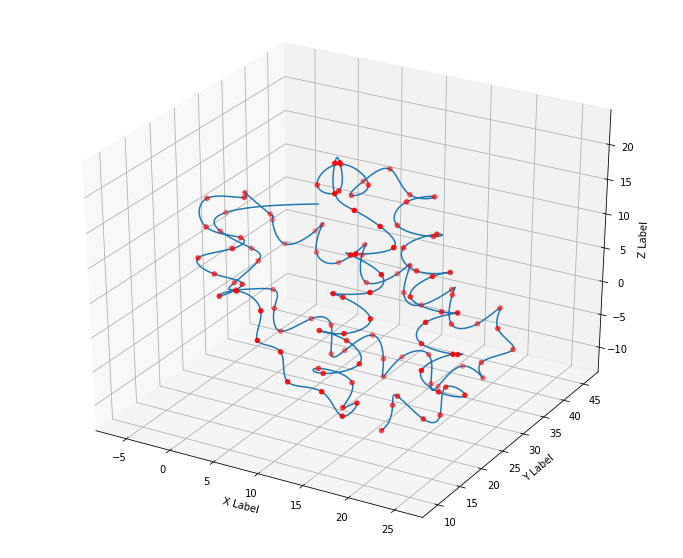

In [38]:
obtain('protein0.txt')
spline(protein)

I now can form my own helicity function and test it out on the different proteins. For mine, I decided to use the cross-product of the 2nd and 3rd derivatives in order to generate a vector similar to the binormal vector. The reason that I didn't use the Frenet-Seret formulas involved the shift of the binormal vector throughout a spiral, whereas I wanted a vector that had close to no change during a helix on the protein.

In [39]:
def helD_peek(protein):
    x_d = csx.derivative()
    y_d = csy.derivative()
    z_d = csz.derivative()
    x2_d = x_d.derivative()
    y2_d = y_d.derivative()
    z2_d = z_d.derivative()
    x3_d = x2_d.derivative()
    y3_d = y2_d.derivative()
    z3_d = z2_d.derivative()
    use = []
    global used
    used = []
    global xaxis
    xaxis = []

    for i in range(1,len(xdata)):
        step1 = np.array([x2_d(i),y2_d(i),z2_d(i)])
        step1 = step1 / ((step1**2).sum()**0.5)
        step2 = np.array([x3_d(i),y3_d(i),z3_d(i)])
        step2 = step2 / ((step2**2).sum()**0.5)
        cross = np.cross(step1, step2)
        cross = cross / ((cross**2).sum()**0.5)
        use.append(cross)
    
    for a in range(1,len(xdata)-1):
        xaxis.append(a)
        usedata = np.subtract(use[a],use[a-1])
        used.append((usedata**2).sum()**0.5)

def graph_peek(protein,threshold):
    keep = []
    discard = []
    for a in range(1,len(protein)-2):
        if used[a] < threshold:
            keep.append(a)
        if used[a] >= threshold:
            discard.append(a)

    global peek_x
    global peek_y
    global peek_z
    global nopeek_x
    global nopeek_y
    global nopeek_z
    peek_x=[]
    peek_y=[]
    peek_z=[]
    nopeek_x = []
    nopeek_y = []
    nopeek_z = []
    for a in keep:
        peek_x.append(protein[a][0])
        peek_y.append(protein[a][1])
        peek_z.append(protein[a][2])
    for a in discard:
        nopeek_x.append(protein[a][0])
        nopeek_y.append(protein[a][1])
        nopeek_z.append(protein[a][2])
    
    new_fig = plt.figure(figsize = [12, 10])
    new_ax = new_fig.add_subplot(111, projection='3d')
    new_ax.scatter(peek_x, peek_y, peek_z, '.r-', c='b', marker='o')
    new_ax.scatter(nopeek_x, nopeek_y, nopeek_z, '.r-', c='r', marker='o')
    plt.plot(csx(test),csy(test),csz(test), c='y')
    new_ax.set_xlabel('X Label')
    new_ax.set_ylabel('Y Label')
    new_ax.set_zlabel('Z Label')
    plt.show()

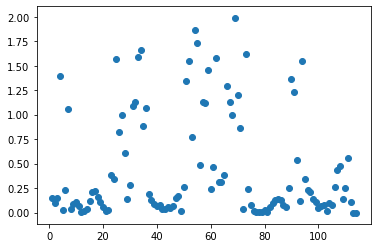

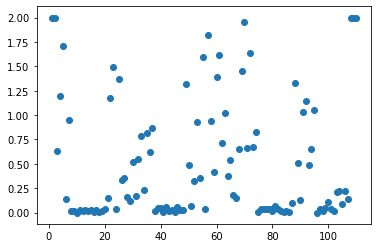

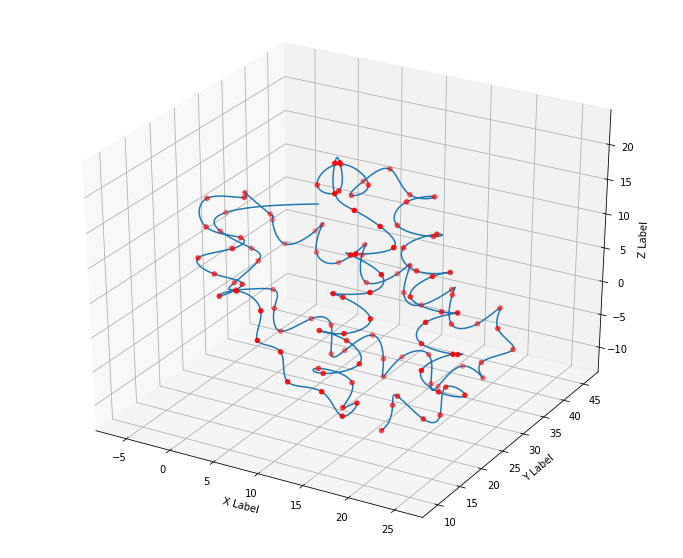

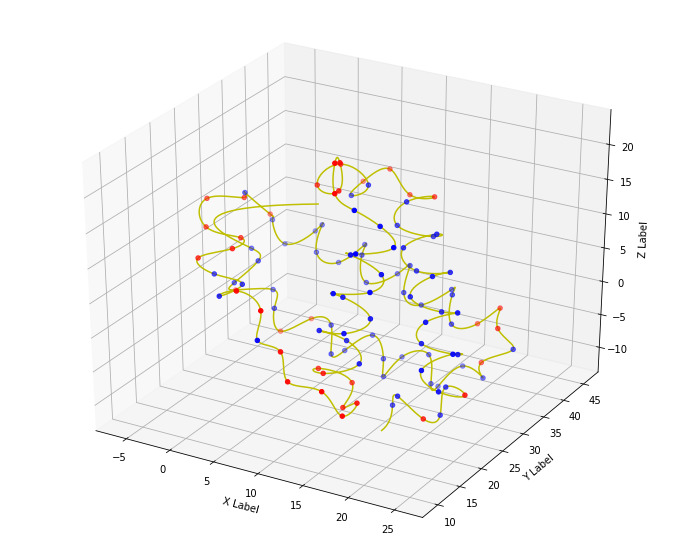

In [41]:
helD_peek(protein)
plt.scatter(xaxis,used)
plt.show()

obtain('protein0.txt')
helD_seg(protein)
spline(protein)
graph_peek(protein, 0.4)

Comparing this normed data to the discrete helicity function, note that the residues resembling helices coincide with both graphs having nearly zero norms. While the norms capture roughly the same information, the cubic spline helicity function is easier to explain or outline the vectors under question in my opinion. However, the residues resembling helices were closer to zero in the discrete helicity function, which allows for the user to provide an easier cutoff value for the norms. Whereas, in my helicity function the threshold was a little harder to set in order to capture every residue along a spiral, as sometimes a single residue in the middle of a helix may have been left out. 

My next step will be to separate the residues along the ꭤ-helices from the residues along the 𝛽-sheets, as I formerly demonstrated with the discrete helicity function. I will capture the residues along the ꭤ-helices in blue and the other residues will be captured in red. Note that there are some discrepancies, as with any helicity function, that are open to debate on whether the residue lies along a helix. I also kept the cubic spline graph to represent the protein backbone, rather than the piecewise segments of the backbone, to better represent the ꭤ-helices apart from the 𝛽-sheets.

One problem that arises from my method, along with most methods, consist of an ꭤ-helix that is moving along a line with greater curvature, rather than a straight line. In other words, in the graph below toward some end points, found near the top left of the graph, there are residues resembling a helix that are colored red. This may be due to the fact that the ꭤ-helix is tilting along the spiral, which causes consecutive vectors to have a grater norm in the previous plot.


## Power of Python and Jupyter

First off, I strongly recommend using Jupyter notebooks to implement and organize code since it provided nice visuals and helped keep my code clean. With Jupyter notebooks you can also code in other languages, such as R, so the interface is not just restricted to Python. There is also a slideshow option on Jupyter that can be used in presentations, and only requires the use of a drop down menu to set the slides and one line of code in the terminal. Even with presenting the notebook without slides, headings and markdown cells may be used to comment on any of the code and visuals programmed. I found these cells more convenient than commenting out my code in other editors, since the comments will never interfere with the code and there is no confusion on which part is code and which is comments. Also, the comments resembled the font from a document, rather than becoming a blue italicized line with a symbol in front.

One nice thing about Python involves many packages that have built in functions, allowing me to take a cross-product and normalize vectors conveniently (of which I was attempting by hand at first). The graphing technology was also convenient and the biggest problem arised from just formatting the data into the type I wanted.

## Conclusion

To conclude, we ran the discretized helicity function through the classification system, sorting out the residues along the helices from the other residues. However, the accuracy of the classification for the proteins we sampled diminished. Therefore, the attempt to feed only the helices into the system and examine the topological properties did not contribute any accuracy to classifying the protein.

An area to improve upon the code may come about by the problem that single residues or pairs of residues may have been considered to lie along a helix, but the surrounding neighborhood of the residues were all considered to lie along a 𝛽-sheet. Examples of this can be found in the above helicity functions when I color coded the three-dimensional plots of the protein backbones. Therefore, it may be beneficial upon further research to include lines of code that would discard residues if the surrounding neighborhood of that particular residue is considered to lie along a 𝛽-sheet. Again, another area to improve upon could be to test for curvature in the Frenet-Serret formulae, which may help counteract the problem I ran into with helices rotating.